## Building plates, slabs and faults

In [1]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

importing Jupyter notebook from tectModelClass.ipynb


In [2]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [3]:
#from unsupported_dan.UWsubduction.base_params import *
#from unsupported_dan.UWsubduction.subduction_utils import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection


from unsupported_dan.UWsubduction.base_params import *
from unsupported_dan.UWsubduction.subduction_utils import *

../unsupported/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [4]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Physical model

In [5]:
yres = int(md.res)
xres = int(md.res*12) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)

In [6]:
#(1. - mesh.minCoord[1])*2900

## Build plate model

In [7]:
#Set up some velocityies
cm2ms = (1/100.)*(1./(3600*24*365)) 

v1= 2.*cm2ms #m/s
v1 /= sf.velocity

v2= -2.*cm2ms #
v2 /= sf.velocity



ma2s = 1e6*(3600*24*365)
endTime = 20*ma2s/sf.time
dt = 0.1*ma2s/sf.time
testTime = 5*ma2s/sf.time


In [8]:
#20 Ma moddel, timestep of 200 Ka 
tg = TectModel(mesh, 0, endTime, dt)

tg.add_plate(1, velocities = v1)
tg.add_plate(2,velocities = v2)
tg.add_plate(3)

In [9]:
tg.add_left_boundary(1)
tg.add_subzone(1, 2, ndp.subZoneLoc, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)
tg.add_subzone(3, 2., 0.4, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)

tg.add_right_boundary(3, 0.)

## Build plate age


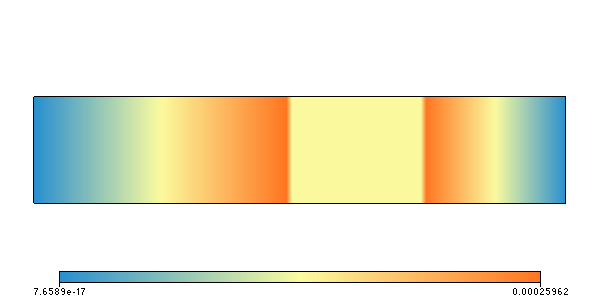

In [10]:
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(tg.mesh, fnAge_map ))
fig.show()

In [11]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]
plateTempProxFn = ndp.potentialTemp*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))


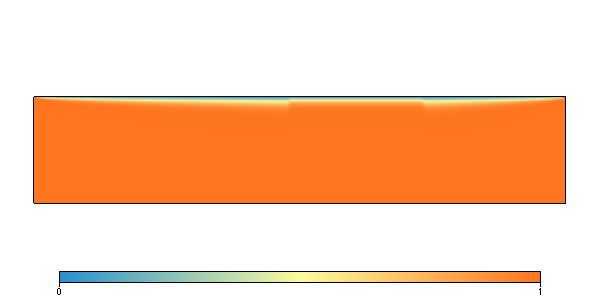

In [12]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(tg.mesh, plateTempProxFn))
fig.show()

## Make swarm and Slabs

In [13]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(20))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [14]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the fucntiosn 
#wthout blowing out the function arguments

tmUwMap = tm_uw_map(temperatureField, velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)




In [15]:
#define fault particle spacing, here ~5 paricles per element
ds = (tg.maxX - tg.minX)/(5.*tg.mesh.elementRes[0])

fCollection = line_collection([])

testThickness = 3*ndp.faultThickness
testFaultDepth = 3*ndp.faultThickness


for e in tg.undirected.edges():
    if tg.is_subduction_boundary(e):
        build_slab_distance(tg, e, linearGradientFn, ndp.maxDepth, tmUwMap)        
        temp = build_fault(tg, e, linearGradientFn,testThickness , ndp.maxDepth, ds, testFaultDepth, tmUwMap)
        fCollection.append(temp)

#
build_slab_temp(tmUwMap, ndp.potentialTemp, ndp.slabMaxAge)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

In [16]:
#ndp.maxDepth*2900


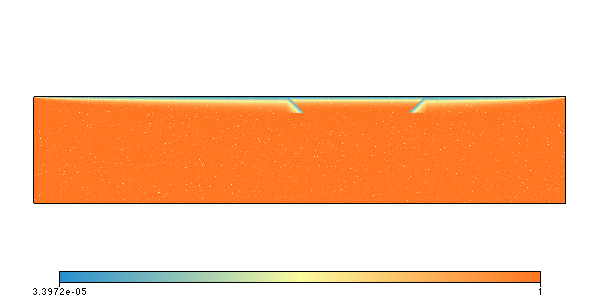

In [17]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Points(swarm, fnJointTemp))
    

fig.show()
#fig.save_database('test.gldb')

In [18]:
#ft = build_fault((1,2), linearGradientFn, ndp.maxDepth, ndp.faultThickness, signedDistanceVariable, proxyTempVariable)

In [19]:
#ft.ID

##  Fault rebuild

In [22]:
# Setup a swarm to define the replacment positions

fThick= fCollection[0].thickness

faultloc = 1. - ndp.faultThickness*md.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys

In [23]:
ridgedist = 100e3/sf.lengthScale
subdist = 150e3/sf.lengthScale


ridgeMaskFn = tg.ridge_mask_fn(ridgedist)
subMaskFn = tg.subduction_mask_fn(subdist)
boundMaskFn = tg.combine_mask_fn(ridgeMaskFn , subMaskFn )


In [24]:
dummy = remove_faults_from_boundaries(fCollection, ridgeMaskFn)
dummy = remove_fault_drift(fCollection, faultloc)

In [25]:
#Deliberately remove some particles to test
f = fCollection[0]

with f.swarm.deform_swarm():
    mean = f.swarm.particleCoordinates.data[:,0].mean()
    mask = (f.swarm.particleCoordinates.data[:,0] < mean)
    with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[mask] = (999999.,999999.)
           
#rebuild the KDtree
f.rebuild()

In [26]:
#now try to add fault particles back in
#dummy = add_particles(tg, fCollection, tmUwMap , boundMaskFn, ds)

dummy = add_particles(tg, fCollection, faultMasterSwarm, boundMaskFn, ds)

In [27]:
#ds*2900.


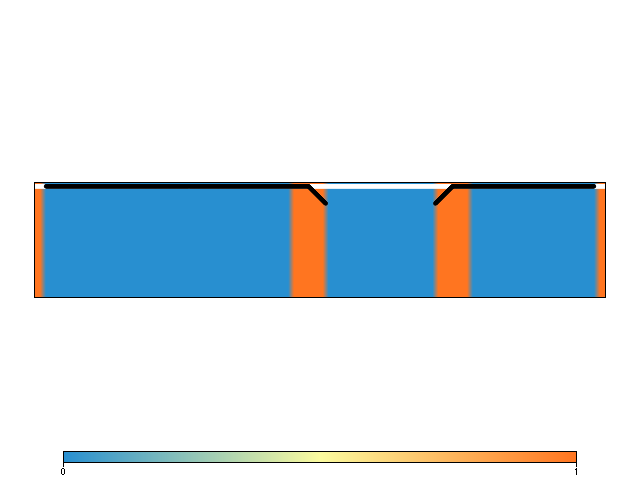

In [28]:
fig2 = glucifer.Figure()
#fig2.append( glucifer.objects.Points(swarm, fnJointTemp, pointSize=0.01))

for f in fCollection:
    fig2.append( glucifer.objects.Points(f.swarm, pointSize=5))

fig2.append( glucifer.objects.Surface(mesh, boundMaskFn ))

fig2.append( glucifer.objects.Points(faultMasterSwarm , pointSize=5, colour='white'))

fig2.show()
#fig2.save_database('test.gldb')

## Proximity



In [29]:
proximityVariable.data[:] = 0

In [30]:
for f in fCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)

In [31]:
#fCollection[0].set_proximity_director(swarm, proximityVariable, locFac=1.)


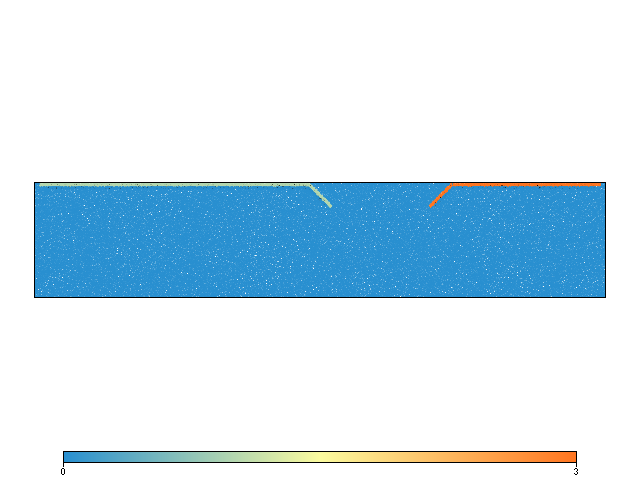

In [32]:
fig3 = glucifer.Figure()
#fig2.append( glucifer.objects.Points(swarm, fnJointTemp, pointSize=0.01))


fig3.append( glucifer.objects.Points(swarm , proximityVariable))

for f in fCollection:
    fig3.append( glucifer.objects.Points(f.swarm, pointSize=5))

fig3.show()
#fig3.save_database('test.gldb')

In [33]:
tg[1]

{1: {'ages': {1: 0.0}, 'loc': -0.8620689655172414},
 2: {'ages': {1: 0.00026248751486325803, 2: 0.00013124375743162902},
  'loc': -0.034482758620689655}}